In [1]:
import signal_ana as ana
import pandas as pd
%load_ext autoreload
%autoreload 2

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
use_wf = True
use_lpc = False
use_amp = False

In [3]:
# Load the signals
df = ana.load_signals('features_30.h5')

In [4]:
df.head()
# decimated_vlp_waveform

,time,waveform,lpc_coeff,amplitude
0,2019-05-27 18:16:37+00:00,"[3.72132730069, -51.1812948272, -104.97754986,...","[1.0, -2.18162593255, 2.49176485988, -1.993432...","[0.390425590627, 0.366654576689, 0.33067666624..."
1,2019-05-27 17:31:45+00:00,"[267.286223554, 213.095748702, 156.62064283, 9...","[1.0, -1.91957893956, 1.75126094982, -1.247919...","[0.304056059595, 0.328030528642, 0.44393763535..."
2,2019-05-27 17:17:41+00:00,"[-150.572442193, -248.678406427, -332.00272918...","[1.0, -2.23007592873, 2.50516095499, -2.071459...","[0.661311999342, 0.584146916956, 0.42782305131..."
3,2019-05-27 19:23:49+00:00,"[-220.99252159, -347.395354446, -449.371607879...","[1.0, -2.32914670106, 2.68123537773, -2.092240...","[0.382224472907, 0.586558602969, 0.38374742891..."
4,2019-05-27 20:41:11+00:00,"[157.167620135, 286.219708967, 395.840778773, ...","[1.0, -2.38909167965, 2.78044991558, -2.351892...","[0.430395495412, 0.381969445864, 0.41658439725..."


In [5]:
# Scale to zero mean and unit variance
ana.normalize(df, 'waveform')
ana.normalize(df, 'lpc_coeff')
ana.normalize(df, 'amplitude')

In [6]:
# Exclude the eruption days
eruption_days = [ ('2019-07-03', '2019-07-04'), ('2019-08-28', '2019-08-29'), ('2019-08-29', '2019-08-30')]
df = ana.exclude_days(df, eruption_days)

In [7]:
# Select a test period
df_test = ana.test_period(df)

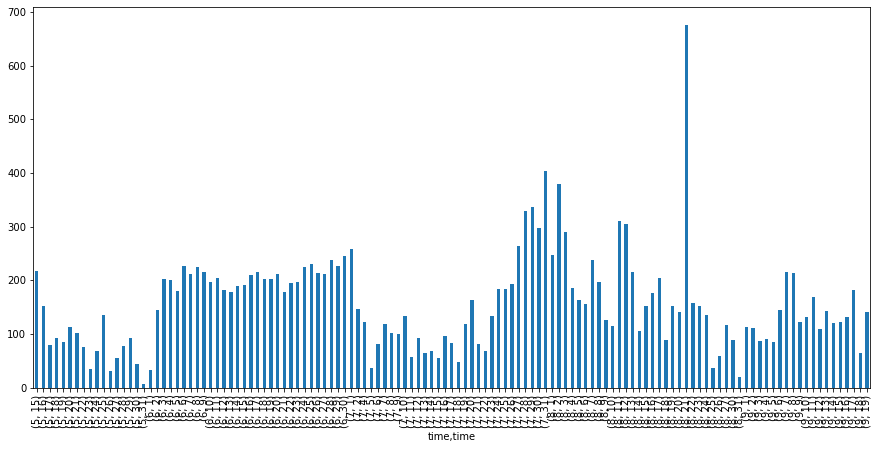

In [7]:
# Frequency of signals per day
ana.plot_freq(df)

In [9]:
features = ana.get_features(df, wf = use_wf, lpc=use_lpc, amp=use_amp)

In [10]:
# Train som

size_x = 25
size_y = 25
niter = 59000 #10000
sigma = 2.2 # #0.3
learning_rate= .013 #.5
pca=False
random_seed = 2

"""
size_x = 10
size_y = 6
niter = 50000 #20000 #10000
sigma = 1.23 # #0.3
learning_rate= .04 #.5
pca=False
random_seed = 2
"""

'\nsize_x = 10\nsize_y = 6\nniter = 50000 #20000 #10000\nsigma = 1.23 # #0.3\nlearning_rate= .04 #.5\npca=False\nrandom_seed = 2\n'

0.37993418318
0.393842286654
0.38194677515
0.369808179674
0.358972344033
0.352219741545
0.346136509753
0.34106707948
0.337855682024
0.333766528774
0.329840066109
0.326182612278
0.32324596523
0.31987205886
0.317168909588
0.314963516115
0.312637798608
0.310183981346
0.30787515378
0.305618448276
0.303512712573
0.301362092928
0.299203351205
0.297229473108
0.295845629676
0.294070576298
0.292283803547
0.29036220836
0.288547761798
0.287042815204
0.285842230446
0.284175735386
0.282863406487
0.281392895207
0.280144431041
0.278585001183
0.277494577302
0.276210550692
0.274927688312
0.273696765854
0.272585200673
0.271551726497
0.270490761333
0.269428810704
0.268332624848
0.267354468545
0.266344718868
0.265510253758
0.264453936314
0.263470912149
0.26245282696
0.261720943095
0.260988980176
0.260120803641
0.259325195265
0.258548095148
0.257790750188
0.257090209541
0.256364111282


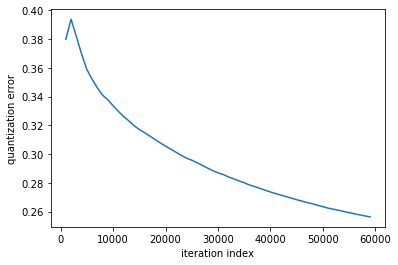

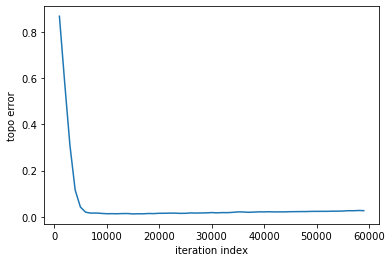

In [11]:
som = ana.run_som(features, size_x, size_y, niter = niter, sigma=sigma, learning_rate=learning_rate, 
                  pca=pca, plot_error = True, random_seed = random_seed)

In [ ]:
from skopt.space import Real, Categorical, Integer

# Skopt dimensions
skopt_dims = [       
    Real(        low=1e-2, high=1,     prior='log-uniform', name='learning_rate'     ),
    Real(        low=.1,    high=5,                         name='sigma'     ),
    Real(     low=1e2,    high=1e5,   prior='log-uniform', name='niter'       )
]

# Initial parameters
init_param = {'learning_rate':0.5, 'sigma':0.3, 'niter' : 10000}

search_result = ana.optimize(skopt_dims, init_param, features, size_x, size_y,
                             num_calls=20, pca = pca, random_seed = random_seed)

In [ ]:
search_result

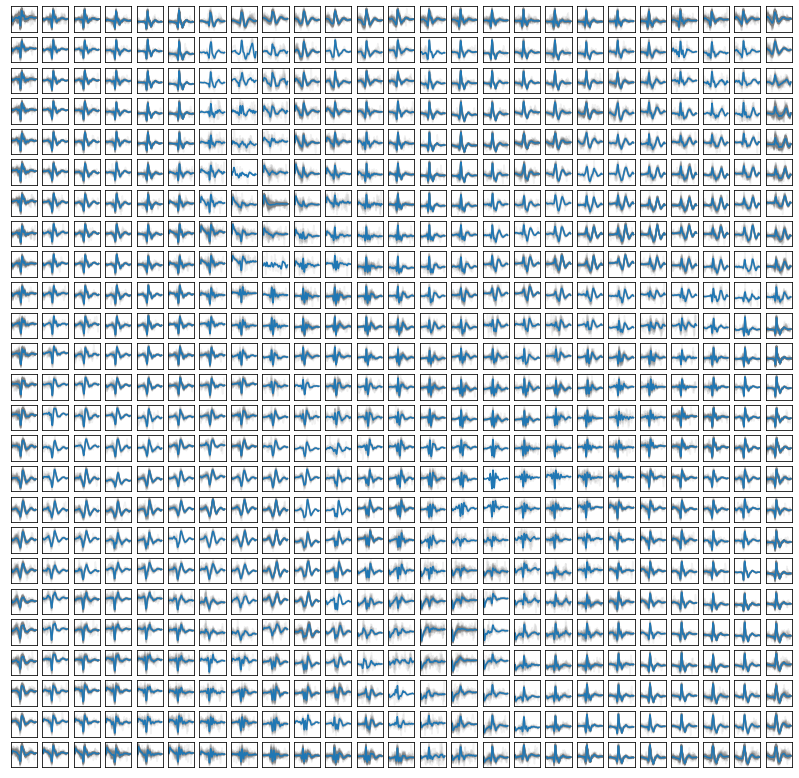

In [12]:
ana.plot_waveforms(features, som, size_x, size_y )

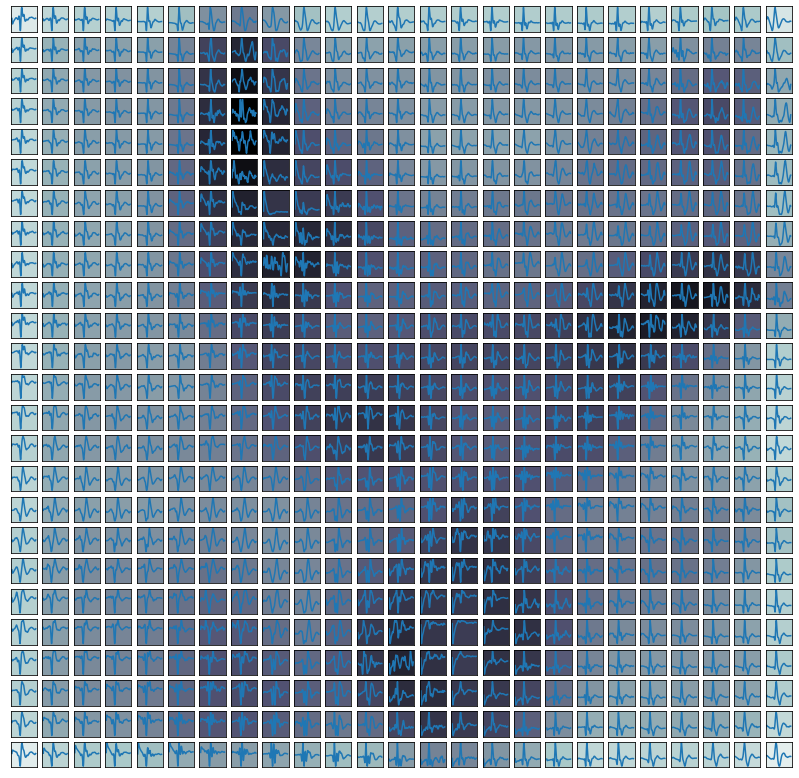

In [13]:
ana.plot_dmap(features, som, size_x, size_y)

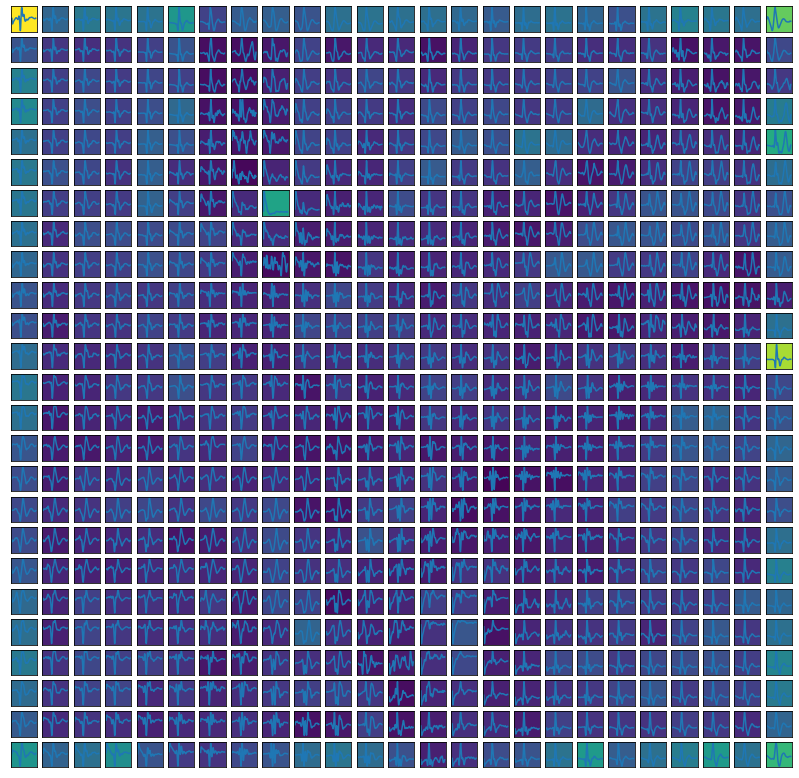

In [14]:
ana.plot_density(features, som, size_x, size_y )

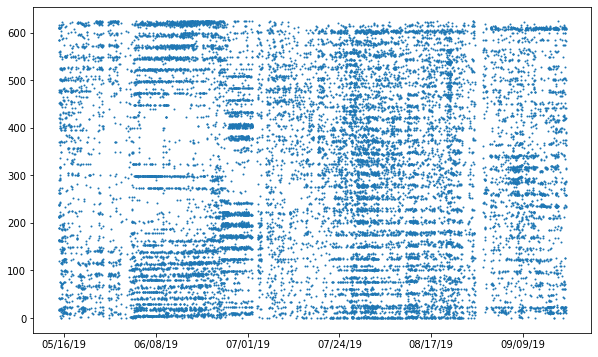

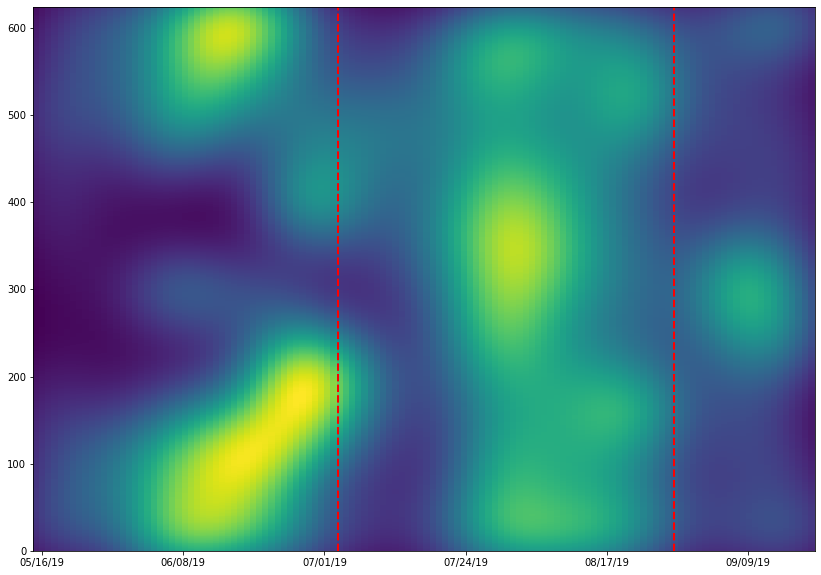

In [15]:
ana.plot_evo(df, som, size_x, size_y, wf = use_wf, lpc = use_lpc, amp = use_amp)

In [64]:
from sklearn.manifold import TSNE  
from sklearn.decomposition import PCA

In [133]:
avg_vec = list(features)

perplexity = 40 #50 # 40
#pca_50 = PCA(n_components=50)
# low early_ex looks good
#pca_result_50 = pca_50.fit_transform(list(features))
tsne_model = TSNE(perplexity=perplexity, early_exaggeration = 500, # learning_rate = 500.00, early_exaggeration = 50,
                  n_components=2, init='pca', n_iter=1000, random_state=23, verbose=2)
tsne_values = tsne_model.fit_transform(list(avg_vec))
#tsne_values = tsne_model.fit_transform(pca_result_50)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 19748 samples in 0.382s...
[t-SNE] Computed neighbors for 19748 samples in 122.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19748
[t-SNE] Computed conditional probabilities for sample 2000 / 19748
[t-SNE] Computed conditional probabilities for sample 3000 / 19748
[t-SNE] Computed conditional probabilities for sample 4000 / 19748
[t-SNE] Computed conditional probabilities for sample 5000 / 19748
[t-SNE] Computed conditional probabilities for sample 6000 / 19748
[t-SNE] Computed conditional probabilities for sample 7000 / 19748
[t-SNE] Computed conditional probabilities for sample 8000 / 19748
[t-SNE] Computed conditional probabilities for sample 9000 / 19748
[t-SNE] Computed conditional probabilities for sample 10000 / 19748
[t-SNE] Computed conditional probabilities for sample 11000 / 19748
[t-SNE] Computed conditional probabilities for sample 12000 / 19748
[t-SNE] Computed conditional probabilities for 

In [127]:
import matplotlib.pyplot as plt


In [134]:
x = tsne_values[:,0]
y = tsne_values[:,1]

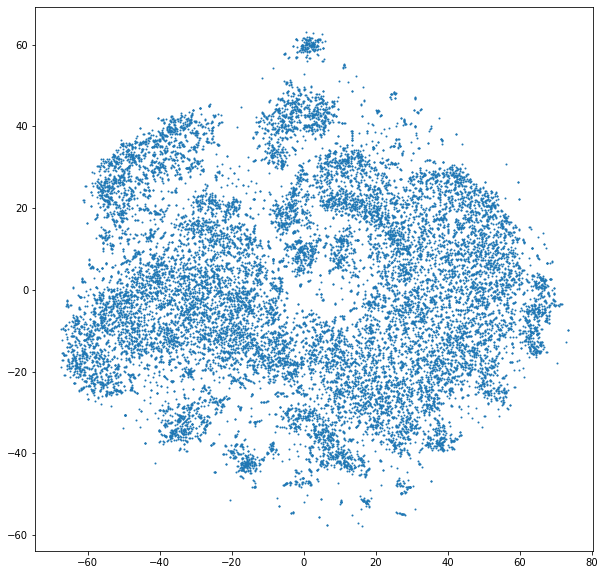

In [135]:
plt.figure(figsize=(10,10))
plt.scatter(x,y, s=1)

In [90]:
weights = som.get_weights()

In [91]:
weights = weights.reshape(size_x * size_y, weights.shape[2])

In [92]:
weights.shape

(625, 259)

In [93]:
from sklearn.cluster import KMeans

In [136]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(features)

In [137]:
pred_y = kmeans.fit_predict(features)

In [96]:
kmeans = KMeans(n_clusters=4, random_state=0)
pred_weights = kmeans.fit_predict(weights)

In [97]:
pred_weights.shape

(625,)

In [99]:
weights = weights.reshape(size_x , size_y, weights.shape[1])

In [100]:
pred_weights = pred_weights.reshape(size_x , size_y,)

In [101]:
weights.shape

(25, 25, 259)

In [102]:
from matplotlib.gridspec import GridSpec
import numpy as np


def plot_dmap(weights, preds, som, size_x, size_y):
    
    win_map = som.win_map(features)
    colors = 'rgbcy'
    
    plt.figure(figsize=(14, 14))
    the_grid = GridSpec(size_x, size_y)

    dmap = som.distance_map() 
    for i in range(size_x):
        for j in range(size_y):

            ax = plt.subplot(the_grid[i, j])
            c = preds[i,j]
            ax.set_facecolor(colors[c])
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            if (i, j) in win_map.keys():
                plt.plot(np.mean(win_map[i, j], axis=0))

    plt.show()

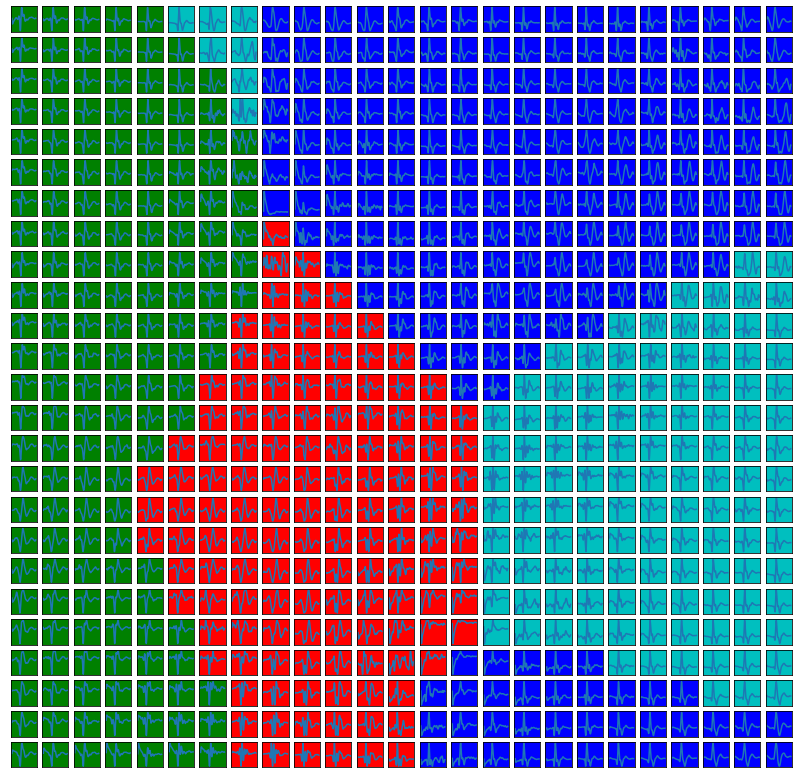

In [103]:
plot_dmap(weights, pred_weights, som, size_x, size_y)

In [138]:
df['cluster'] = pred_y

In [139]:
df['t-sne_x'] = tsne_values[:,0]

In [140]:
df['t-sne_y'] = tsne_values[:,1]

In [109]:
df.head()

,time,waveform,lpc_coeff,amplitude,cluster,cluster_index,time_int,t-sne_x,t-sne_y
0,2019-05-27 18:16:37+00:00,"[0.0158810999017, -0.0367588506569, -0.0883380...","[0.532978581546, -1.2006501701, 1.34582286513,...","[-0.80383077214, -0.83517702322, -0.8826202083...",7,65,1558980997000000000,-65.898735,11.887994
1,2019-05-27 17:31:45+00:00,"[0.217929382801, 0.177055765433, 0.13445894607...","[0.546929495243, -1.05886855439, 0.96013064272...","[-1.17846643712, -1.13786962252, -0.9416000278...",7,118,1558978305000000000,-80.509468,9.467527
2,2019-05-27 17:17:41+00:00,"[-0.149794678508, -0.260617692893, -0.35474298...","[0.483930108041, -1.09174501829, 1.21816816629...","[-0.576909810157, -0.708350230084, -0.97462707...",7,42,1558977461000000000,-60.873833,27.929199
3,2019-05-27 19:23:49+00:00,"[-0.191800774518, -0.317321693705, -0.41858645...","[0.4570894207, -1.07637940861, 1.23149868469, ...","[-1.0065168605, -0.673603467102, -1.0040355694...",7,92,1558985029000000000,-74.280289,12.384934
4,2019-05-27 20:41:11+00:00,"[0.102960507618, 0.205200011241, 0.29204559324...","[0.495109947081, -1.20351900811, 1.38747995821...","[-0.714479105475, -0.775221954741, -0.73180295...",1,595,1558989671000000000,-51.414059,-34.752834


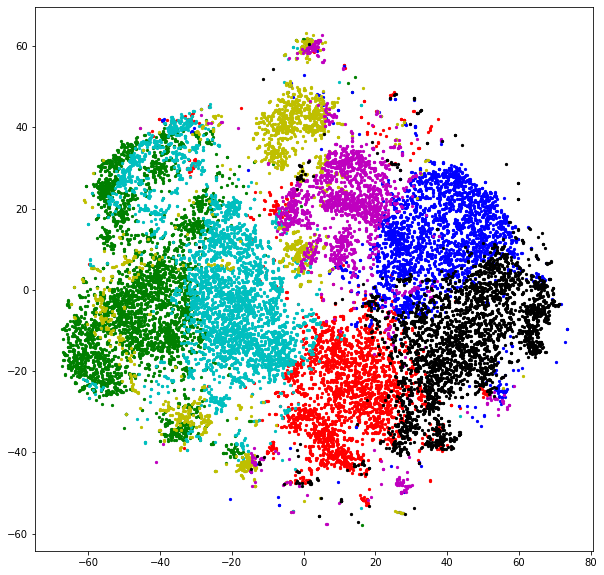

In [146]:
colors = 'rgbcymk'


plt.figure(figsize=(10,10))
for i in range(7):
    
    cls = df[df['cluster']==i]
    plt.scatter(cls['t-sne_x'], cls['t-sne_y'], c = colors[i], s = 5)
    

r


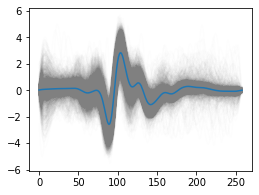

g


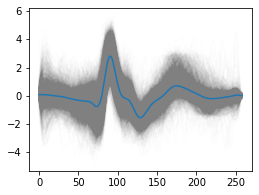

b


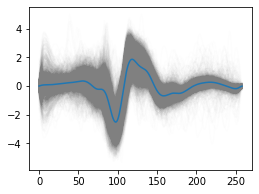

c


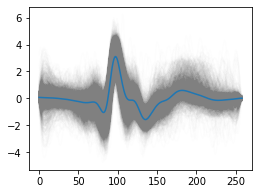

y


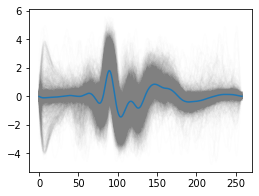

m


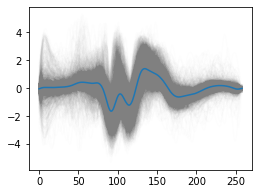

k


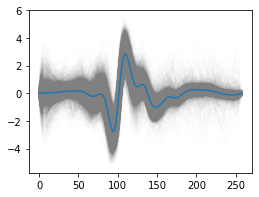

In [148]:
for i in range(7):
    
    cls = df[df['cluster']==i]
    print(colors[i])
    plt.figure(figsize=(4,3))
    for vec in cls['waveform']:
        plt.plot(vec, color='gray', alpha=.01)
    plt.plot(np.mean(cls['waveform'], axis=0))
    plt.show()